In [1]:
#read in weather_events parquet
import pandas as pd
data=pd.read_parquet('weather_events.parquet')
data.head()

,location_id,time,temperature_2m,relative_humidity_2m,rain,pressure_msl,surface_pressure,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,soil_temperature_0_to_7cm,county_name,tornado,wind_shear
0,0,2018-01-01 00:00:00,-21.2,72,0.0,1050.5,989.6,8.1,18.0,298,305,19.1,Lyon,0,10.01
1,0,2018-01-01 01:00:00,-20.7,72,0.0,1050.7,989.9,8.1,17.8,304,310,18.9,Lyon,0,9.78
2,0,2018-01-01 02:00:00,-20.2,71,0.0,1050.5,989.8,7.5,17.2,307,314,18.8,Lyon,0,9.80
3,0,2018-01-01 03:00:00,-20.0,71,0.0,1050.6,989.9,6.9,16.3,303,314,18.6,Lyon,0,9.62
4,0,2018-01-01 04:00:00,-20.2,70,0.0,1050.8,990.1,6.3,15.5,297,311,18.5,Lyon,0,9.51


In [42]:
X = data.drop(columns=['tornado', 'time','county_name', 'location_id'])
y = data['tornado']

from sklearn.model_selection import train_test_split

# First split: Train + Validation and Test (hold-out)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=96)

# Second split: Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=96)

# At this point, X_train_val and y_train_val are no longer needed
del X_train_val, y_train_val

In [43]:
weight=data['tornado'].value_counts()[0]/data['tornado'].value_counts()[1]
weight

4581.584507042254

In [4]:
#calculate the weight of each set y_train, y_val, y_test
print(y_train.value_counts()[0]/y_train.value_counts()[1])
print(y_val.value_counts()[0]/y_val.value_counts()[1])
print(y_test.value_counts()[0]/y_test.value_counts()[1])

4578.895894428152
4585.621145374449
4585.625550660793


In [45]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Initialize base models
xgb_model = XGBClassifier(scale_pos_weight=weight,learning_rate=0.3, max_depth=9)
cat_model = catboost=CatBoostClassifier(scale_pos_weight=weight, verbose=False, save_snapshot=False, learning_rate=0.3, depth=9)

# Train base models
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=True)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=True)

#logloss
from sklearn.metrics import log_loss
y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_cat = cat_model.predict_proba(X_test)[:, 1]

print(f'XGBoost log loss: {log_loss(y_test, y_pred_xgb)}')
print(f'CatBoost log loss: {log_loss(y_test, y_pred_cat)}')

c:\Users\goodm\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.47787
[1]	validation_0-logloss:0.36199
[2]	validation_0-logloss:0.28697
[3]	validation_0-logloss:0.23369
[4]	validation_0-logloss:0.19746
[5]	validation_0-logloss:0.16957
[6]	validation_0-logloss:0.14201
[7]	validation_0-logloss:0.12663
[8]	validation_0-logloss:0.11335
[9]	validation_0-logloss:0.10031
[10]	validation_0-logloss:0.09142
[11]	validation_0-logloss:0.08205
[12]	validation_0-logloss:0.07538
[13]	validation_0-logloss:0.06985
[14]	validation_0-logloss:0.06445
[15]	validation_0-logloss:0.06092
[16]	validation_0-logloss:0.05661
[17]	validation_0-logloss:0.05291
[18]	validation_0-logloss:0.05047
[19]	validation_0-logloss:0.04782
[20]	validation_0-logloss:0.04402
[21]	validation_0-logloss:0.04270
[22]	validation_0-logloss:0.04015
[23]	validation_0-logloss:0.03841
[24]	validation_0-logloss:0.03752
[25]	validation_0-logloss:0.03385
[26]	validation_0-logloss:0.03238
[27]	validation_0-logloss:0.03130
[28]	validation_0-logloss:0.03005
[29]	validation_0-loglos

In [46]:
# Generate predictions for the training set
xgb_train_pred = xgb_model.predict_proba(X_train)[:, 1]
cat_train_pred = cat_model.predict_proba(X_train)[:, 1]

# Generate predictions for the validation set
xgb_val_pred = xgb_model.predict_proba(X_val)[:, 1]
cat_val_pred = cat_model.predict_proba(X_val)[:, 1]

# Generate predictions for the test set
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]
cat_test_pred = cat_model.predict_proba(X_test)[:, 1]


In [47]:
# Stack predictions as new features
import numpy as np
train_stack = np.column_stack((xgb_train_pred, cat_train_pred))
val_stack = np.column_stack((xgb_val_pred, cat_val_pred))
test_stack = np.column_stack((xgb_test_pred, cat_test_pred))


In [18]:
#logistic regression blender
from sklearn.linear_model import LogisticRegression
blender = LogisticRegression(max_iter=1000)
blender.fit(train_stack, y_train)

LogisticRegression(max_iter=1000)

In [48]:
# Initialize and train the XGBoost blender model
blender = XGBClassifier(scale_pos_weight=weight, learning_rate=0.3, max_depth=9)
blender.fit(train_stack, y_train, eval_set=[(val_stack, y_val)], early_stopping_rounds=10, verbose=True)


c:\Users\goodm\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.44004
[1]	validation_0-logloss:0.30063
[2]	validation_0-logloss:0.21321
[3]	validation_0-logloss:0.15511
[4]	validation_0-logloss:0.11525
[5]	validation_0-logloss:0.08742
[6]	validation_0-logloss:0.06778
[7]	validation_0-logloss:0.05387
[8]	validation_0-logloss:0.04401
[9]	validation_0-logloss:0.03705
[10]	validation_0-logloss:0.03217
[11]	validation_0-logloss:0.02879
[12]	validation_0-logloss:0.02648
[13]	validation_0-logloss:0.02492
[14]	validation_0-logloss:0.02390
[15]	validation_0-logloss:0.02324
[16]	validation_0-logloss:0.02283
[17]	validation_0-logloss:0.02258
[18]	validation_0-logloss:0.02244
[19]	validation_0-logloss:0.02235
[20]	validation_0-logloss:0.02231
[21]	validation_0-logloss:0.02229
[22]	validation_0-logloss:0.02229
[23]	validation_0-logloss:0.02229
[24]	validation_0-logloss:0.02230
[25]	validation_0-logloss:0.02231
[26]	validation_0-logloss:0.02232
[27]	validation_0-logloss:0.02234
[28]	validation_0-logloss:0.02236
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [49]:
# Generate predictions from the blender model
blender_train_pred_proba = blender.predict_proba(train_stack)[:, 1]
blender_val_pred_proba = blender.predict_proba(val_stack)[:, 1]
blender_test_pred_proba = blender.predict_proba(test_stack)[:, 1]

# Calculate log loss for the blender model
train_logloss = log_loss(y_train, blender_train_pred_proba)
val_logloss = log_loss(y_val, blender_val_pred_proba)
test_logloss = log_loss(y_test, blender_test_pred_proba)

print(f"Train Log Loss: {train_logloss:.3f}")
print(f"Validation Log Loss: {val_logloss:.3f}")
print(f"Test Log Loss: {test_logloss:.3f}")

Train Log Loss: 0.020
Validation Log Loss: 0.022
Test Log Loss: 0.022


In [50]:
#confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = blender.predict(test_stack)
confusion_matrix(y_test, y_pred)

array([[1036882,    4055],
       [    102,     125]], dtype=int64)

In [52]:
#recall
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

#precision
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")

Precision: 0.030
Recall: 0.551


In [9]:
# Generate predictions from the blender model
blender_train_pred_proba = blender.predict_proba(train_stack)[:, 1]
blender_val_pred_proba = blender.predict_proba(val_stack)[:, 1]
blender_test_pred_proba = blender.predict_proba(test_stack)[:, 1]

# Calculate log loss for the blender model
train_logloss = log_loss(y_train, blender_train_pred_proba)
val_logloss = log_loss(y_val, blender_val_pred_proba)
test_logloss = log_loss(y_test, blender_test_pred_proba)

print(f"Train Log Loss: {train_logloss:.3f}")
print(f"Validation Log Loss: {val_logloss:.3f}")
print(f"Test Log Loss: {test_logloss:.3f}")

Train Log Loss: 0.020
Validation Log Loss: 0.021
Test Log Loss: 0.021


In [41]:
#xgboost standard
xgb_model = XGBClassifier(scale_pos_weight=weight,learning_rate=0.1, max_depth=9)
xgb_model.fit(X_train, y_train, verbose=True)
y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
print(f'XGBoost log loss: {log_loss(y_test, y_pred_xgb)}')

#confusion matrix
y_pred = xgb_model.predict(X_test)
confusion_matrix(y_test, y_pred)

XGBoost log loss: 0.026125085232867662


array([[1029629,   11308],
       [     72,     155]], dtype=int64)

In [37]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=96)

In [39]:
#xgb precision and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')


Precision: 0.014
Recall: 0.683


c:\Users\goodm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best threshold: 0.0


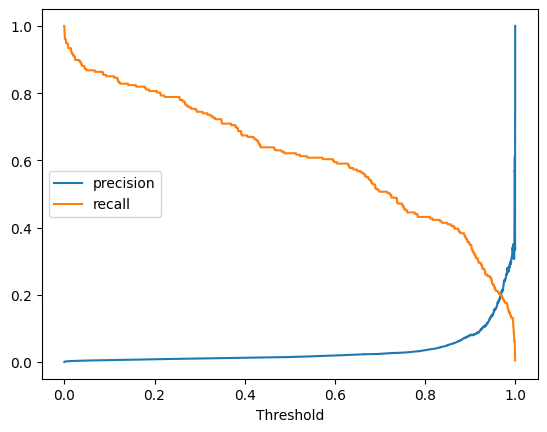

In [33]:
#plot score on y axis and prob threshold on x axis
#plot both recall and precision at different thresholds

#Loop through different thresholds within range, calculate sum. when sum is max, that is the best threshold
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 100)
scores = []
for threshold in thresholds:
    y_pred = (xgb_model.predict_proba(X_test)[:, 1] > threshold).astype(int)
    scores.append(precision_score(y_test, y_pred) + recall_score(y_test, y_pred))

best_threshold = thresholds[np.argmax(scores)]
print(f'Best threshold: {best_threshold}')

#plot precision and recall
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [20]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def find_best_threshold(y_true, y_proba, thresholds):
    best_threshold = 0.5
    best_precision = 0
    best_recall = 0
    best_f1 = 0
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        if f1 > best_f1:
            best_threshold = threshold
            best_precision = precision
            best_recall = recall
            best_f1 = f1
    
    return best_threshold, best_precision, best_recall, best_f1, precisions, recalls, f1_scores

# Define thresholds to evaluate
thresholds = np.arange(0.0, 1.05, 0.05)

# Find the best threshold
best_threshold, best_precision, best_recall, best_f1, precisions, recalls, f1_scores = find_best_threshold(y_test, blender_test_pred_proba, thresholds)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best Precision: {best_precision:.3f}")
print(f"Best Recall: {best_recall:.3f}")
print(f"Best F1 Score: {best_f1:.3f}")


c:\Users\goodm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\goodm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\goodm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Best Threshold: 0.05
Best Precision: 0.214
Best Recall: 0.189
Best F1 Score: 0.201


In [14]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, blender_test_pred_proba >= best_threshold)

array([[1037150,    3787],
       [    120,     107]], dtype=int64)

In [ ]:
#start over and use the entire dataset
# First split: Train + Validation and Test (hold-out)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=96)